In [1]:
import ee

# connect to google account
#ee.Authenticate()
ee.Initialize()

In [2]:
## determine study area and subsets
# define region of interest
studyArea = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -64.51171875,
              59.355596110016315
            ],
            [
              -49.92187499999999,
              63.35212928507874
            ],
            [
              -54.140625,
              71.7739410364347
            ],
            [
              -71.455078125,
              70.28911664330674
            ],
            [
              -64.51171875,
              59.355596110016315
            ]
          ]
        ]
      }
    }
  ]
}

seaIce = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -64.786376953125,
              60.69469537287745
            ],
            [
              -61.8310546875,
              60.69469537287745
            ],
            [
              -61.8310546875,
              61.25966921642908
            ],
            [
              -64.786376953125,
              61.25966921642908
            ],
            [
              -64.786376953125,
              60.69469537287745
            ]
          ]
        ]
      }
    }
  ]
}

In [3]:
from datetime import datetime, timedelta

## select desired image
def createImage(geoJSON, date, polarisation, orbitNumber,orbitPass, clip):
    # set area of interest
    coords = geoJSON['features'][0]['geometry']['coordinates']
    aoi = ee.Geometry.Polygon(coords)
    
    # set date range

    start_date = date
    end_date = str(datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days=1)).split(' ')[0]
    
    # pull boundary
    if clip:
        ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD')
                               .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarisation))
                               .filter(ee.Filter.eq('relativeOrbitNumber_start', orbitNumber))
                               .filter(ee.Filter.eq('orbitProperties_pass', orbitPass))
                               .filter(ee.Filter.eq('instrumentMode', 'IW'))
                               .filterBounds(aoi) 
                               .filterDate(ee.Date(start_date), ee.Date(end_date)) 
                               .first()
                               .clip(aoi)
                         )
    else:
        ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD')
                               .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarisation))
                               .filter(ee.Filter.eq('orbitProperties_pass', orbitPass))
                               .filter(ee.Filter.eq('instrumentMode', 'IW'))
                               .filterBounds(aoi)
                               .filterDate(ee.Date(start_date), ee.Date(end_date)) 
                               .first()
                         )
    ## create map
    location = aoi.centroid().coordinates().getInfo()[::-1]

    # select image
    return ee.Image(ffa_db.select(polarisation))

In [4]:
import geemap

## create map
# set center point and basemap
Map = geemap.Map(center=(75, -100), zoom=4)
Map.add_basemap('HYBRID')

# add layers
vis_params = {'min': -20, 'max': 0}

## add map layers
# study area
Map.addLayer(createImage(studyArea, '2021-01-17', 'VV', 149, 'ASCENDING', False), vis_params, "si_2021-01-17_VV_A")
Map.addLayer(createImage(studyArea, '2021-01-17', 'VH', 149, 'ASCENDING', False), vis_params, "si_2021-01-17_VH_A")

# display map
Map

Map(center=[75, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

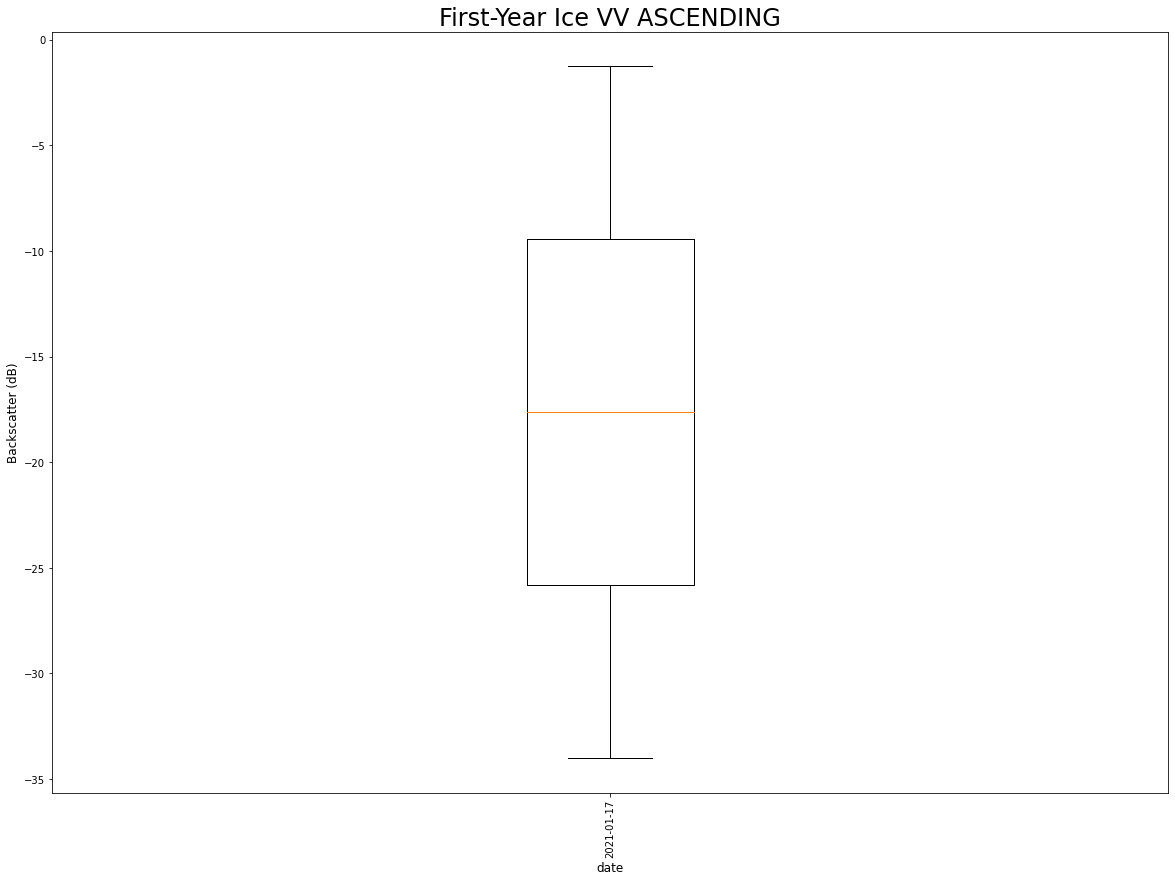

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

dates = [
    '2021-01-17'
]

def createBoxPlot(classification, geoJSON, dates, polarisation, orbitNumber,orbitPass, clip):
    
    x = []
    valid_dates = []
    df = pd.DataFrame(columns=['Classification',
                               'Date',
                               'Polarisation',
                               'Orbit Pass',
                               'Mean',
                               'Variance',
                               'Median',
                               'Standard Deviation',
                               'Mode',
                               'Max',
                               'Min'
                              ])
    mean = 0
    variance = 0
    covariance = 0
    median = 0
    st_dev = 0
    mode = 0
    max_ = 0
    min_ = 0
    for date in dates:
        try:
            # create data
            data = createImage(geoJSON, date, polarisation, orbitNumber,orbitPass, clip)
            hist = data.select(polarisation).reduceRegion(
                ee.Reducer.autoHistogram(), bestEffort=True
            ).get(polarisation).getInfo()
            
            # determine summary statistics
            mean = data.select(polarisation).reduceRegion(
                ee.Reducer.mean(), bestEffort=True
            ).get(polarisation).getInfo()
            variance = data.select(polarisation).reduceRegion(
                ee.Reducer.variance(), bestEffort=True
            ).get(polarisation).getInfo()
            median = data.select(polarisation).reduceRegion(
                ee.Reducer.median(), bestEffort=True
            ).get(polarisation).getInfo()
            std_dev = data.select(polarisation).reduceRegion(
                ee.Reducer.stdDev(), bestEffort=True
            ).get(polarisation).getInfo()
            mode = data.select(polarisation).reduceRegion(
                ee.Reducer.mode(), bestEffort=True
            ).get(polarisation).getInfo()
            max_ = data.select(polarisation).reduceRegion(
                ee.Reducer.max(), bestEffort=True
            ).get(polarisation).getInfo()
            min_ = data.select(polarisation).reduceRegion(
                ee.Reducer.min(), bestEffort=True
            ).get(polarisation).getInfo()
            
            summaryStats = {
                'Classification': [classification],
                'Date': [date],
                'Polarisation': [polarisation],
                'Orbit Pass': [orbitPass],
                'Mean': [mean],
                'Variance': [variance],
                'Median': [median],
                'Standard Deviation': [std_dev],
                'Mode': [mode],
                'Max': [max_],
                'Min': [min_]
            }
            summary = pd.DataFrame(summaryStats)
            df = df.append(summary, ignore_index = True)
            
            # prep data for box and whisker plots
            a = np.array(hist)
            x += [a[:, 0]]
            valid_dates += [date]
        except:
            pass
    filename = 'summary_%s_%s_%s_aa.csv' % (classification, polarisation, orbitPass)
    df.to_csv(filename.replace(' ', '_'))
    fig = plt.figure(figsize =(20, 14))
    ax = fig.add_subplot(111)
    plt.boxplot(x)
    ax.set_xticklabels(valid_dates, rotation = 90)
    ax.set_title('%s %s %s' % (classification, polarisation, orbitPass), fontsize = 24)
    plt.xlabel('date', fontsize=12)
    plt.ylabel('Backscatter (dB)', fontsize=12)
    plt.show()

createBoxPlot('First-Year Ice', seaIce, dates, 'VV', 149, 'ASCENDING', True)

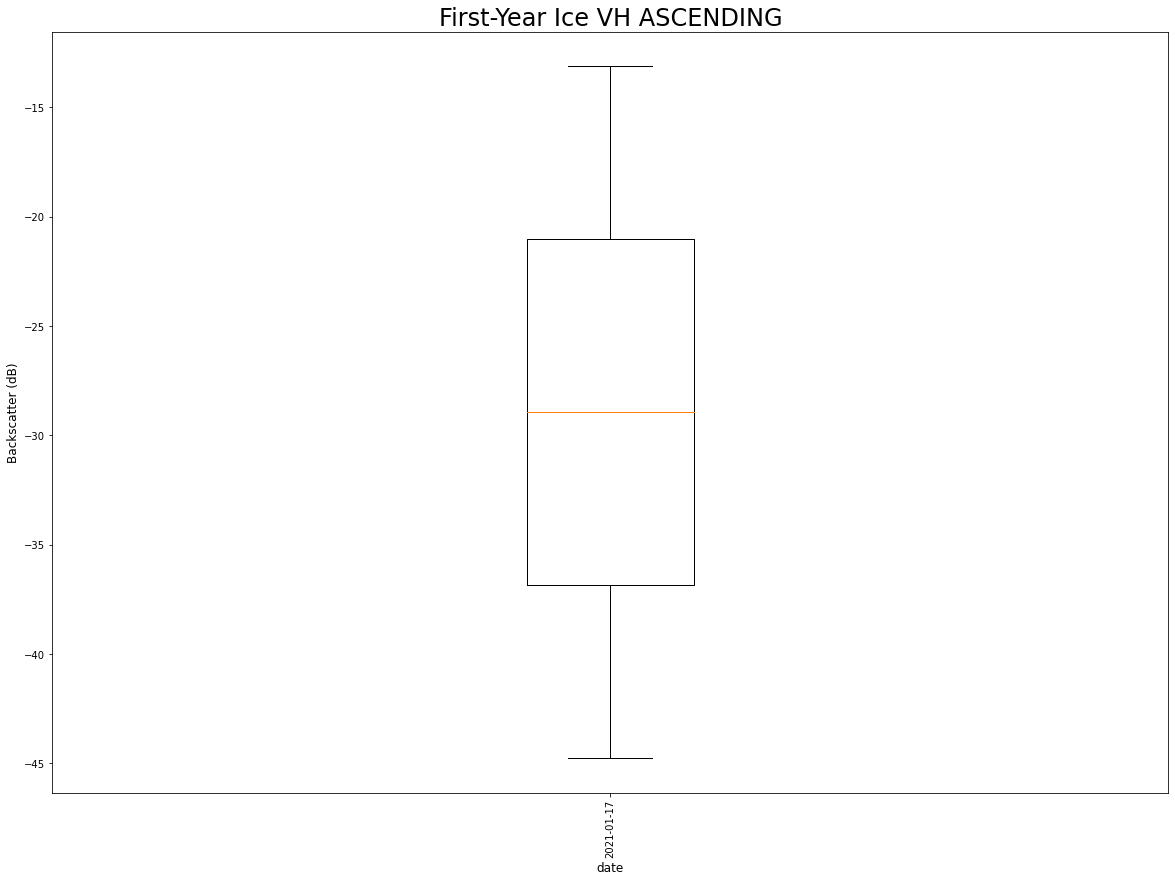

In [6]:
createBoxPlot('First-Year Ice', seaIce, dates, 'VH', 149, 'ASCENDING', True)